# Component Validation

Before a component enters the composite score it must pass three tests:

1. **Conditional returns** — does Q1→Q5 show a monotonic pattern in 5d forward 2s10s returns?
2. **Correlation significance** — is the Pearson r vs forward return statistically significant (p < 0.05)?
3. **Asymmetry check** — does the positive side predict steepening AND the negative side predict flattening independently? Or only one direction works?

Plus two diagnostic tests across all components together:

4. **Ablation study** — does removing each component hurt the composite Sharpe?
5. **Redundancy check** — are any components too correlated with each other (double-counting)?

---
**The six components:**

| # | Component | Raw input | Sign convention | Type |
|---|---|---|---|---|
| 1 | Regime | `regime` label | Contrarian: flattener regime → +1 | Contrarian |
| 2 | Z-score | `2s10s_z20` | `-clip(z20/2)`: flat curve → +1 | Contrarian |
| 3 | Vol-adj | `2s10s_voladj` | `-clip(voladj/2)`: sharp flat move → +1 | Contrarian |
| 4 | Funding | `SOFR_TBill_spread_z20` | `-clip(z20/2)`: high stress → -1 | Contrarian |
| 5 | VIX | `VIX_z20` | `+clip(z20/2)`: high VIX → +1 | Momentum |
| 6 | Front-end | `1y2y_z20` | `+clip(z20/2)`: steep 1y2y → +1 | Momentum |

In [24]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr

from src.data.data_loader import DataLoader
from src.features.feature_engineering import FeatureEngineer
from src.signals.signal_engine import SignalEngine

FRED_KEY = '6871fa0076eb56b3be3858cb458a9bba'
HORIZON  = 5
N_Q      = 5

loader = DataLoader(FRED_KEY)
df     = loader.load_treasury_data()
df     = FeatureEngineer.add_curve_features(df)
df['composite_score'] = SignalEngine.composite_score(df)

print(f'Dataset: {df.index[0].date()} → {df.index[-1].date()}  ({len(df)} trading days)')

Dataset: 2018-04-03 → 2026-02-20  (1969 trading days)


In [25]:
# ── Build component series ────────────────────────────────────────────────────
# These mirror exactly what SignalEngine.composite_score() computes.

def _clip(s, scale=2.0):
    return s.div(scale).clip(-1, 1).fillna(0)

regime_map = {
    'Bear Steepener': -1, 'Bull Steepener': -1,
    'Bear Flattener': +1, 'Bull Flattener': +1,
    'Unknown': 0,
}

components = {
    'Regime':    df['regime'].map(regime_map).fillna(0),
    'Z-score':   _clip(-df['2s10s_z20']),
    'Vol-adj':   _clip(-df['2s10s_voladj']),
    'Funding':   _clip(-df['SOFR_TBill_spread_z20']),
    'VIX':       _clip(df['VIX_z20']),
    'Front-end': _clip(df['1y2y_z20']),
}

# Raw inputs (untransformed) — for correlation tests
raw_inputs = {
    'Regime':    df['regime'].map(regime_map).fillna(0),
    'Z-score':   df['2s10s_z20'],
    'Vol-adj':   df['2s10s_voladj'],
    'Funding':   df['SOFR_TBill_spread_z20'],
    'VIX':       df['VIX_z20'],
    'Front-end': df['1y2y_z20'],
}

# 5d forward return on 2s10s (bps)
fwd = df['2s10s'].diff(HORIZON).shift(-HORIZON) * 100
fwd.name = f'fwd_{HORIZON}d_bps'

print('Components and forward return computed.')
print(f'Forward return NaN (last {HORIZON} days, expected): {fwd.isna().sum()}')

Components and forward return computed.
Forward return NaN (last 5 days, expected): 5


---
## Test 1 — Conditional Returns (Q1→Q5 Monotonicity)

Each component is bucketed into quintiles. For the signal to be valid:
- Q1→Q5 should show a **monotonic pattern** in mean forward return
- The spread between Q1 and Q5 should be economically meaningful
- Hit rate should be above 50% in Q5 and below 50% in Q1

Note: components 1–4 are **contrarian** (low value = steepener signal), so we expect Q1 of the *component* to show positive returns and Q5 to show negative returns. Components 5–6 are **momentum** (high value = steepener signal), so Q5 should show positive returns.

In [26]:
def conditional_returns(signal: pd.Series, fwd: pd.Series, n_q: int = 5) -> pd.DataFrame:
    combined = pd.concat([signal, fwd], axis=1).dropna()
    combined.columns = ['signal', 'fwd']
    combined['q'] = pd.qcut(
        combined['signal'].rank(method='first'),
        q=n_q,
        labels=[f'Q{i}' for i in range(1, n_q + 1)],
    )
    def sharpe(s):
        return s.mean() / s.std() * np.sqrt(252 / HORIZON) if s.std() > 0 else np.nan

    return combined.groupby('q', observed=True)['fwd'].agg(
        mean_return='mean',
        hit_rate=lambda x: (x > 0).mean(),
        sharpe=sharpe,
        count='count',
    ).round(3)

cond_results = {name: conditional_returns(sig, fwd) for name, sig in raw_inputs.items()}
print('Conditional returns computed for all components.')


Conditional returns computed for all components.


In [27]:
from IPython.display import display, HTML

for name, res in cond_results.items():
    display(HTML(f'<h4 style="color:#00bcd4; margin-bottom:4px">{name}</h4>'))
    display(res.style
        .background_gradient(subset=['mean_return'], cmap='RdYlGn')
        .background_gradient(subset=['hit_rate'],    cmap='RdYlGn', vmin=0.35, vmax=0.65)
        .format({'mean_return': '{:+.3f}', 'hit_rate': '{:.3f}', 'sharpe': '{:+.3f}', 'count': '{:d}'}))


,mean_return,hit_rate,sharpe,count
q,,,,
Q1,-0.216,0.384,-0.258,393
Q2,-0.827,0.433,-0.595,393
Q3,+0.176,0.444,+0.217,392
Q4,-0.275,0.481,-0.229,393
Q5,+1.282,0.514,+0.948,393


,mean_return,hit_rate,sharpe,count
q,,,,
Q1,+0.807,0.517,+0.636,389
Q2,-0.586,0.445,-0.506,389
Q3,+0.545,0.455,+0.536,389
Q4,+0.316,0.442,+0.277,389
Q5,-0.879,0.406,-0.765,389


,mean_return,hit_rate,sharpe,count
q,,,,
Q1,+1.728,0.560,+1.426,389
Q2,+0.162,0.455,+0.152,389
Q3,-0.291,0.436,-0.277,388
Q4,-1.527,0.383,-1.317,389
Q5,+0.131,0.432,+0.107,389


,mean_return,hit_rate,sharpe,count
q,,,,
Q1,-0.455,0.455,-0.316,389
Q2,+0.090,0.450,+0.086,389
Q3,-0.077,0.465,-0.081,389
Q4,+0.062,0.452,+0.059,389
Q5,+0.584,0.442,+0.484,389


,mean_return,hit_rate,sharpe,count
q,,,,
Q1,-1.167,0.398,-1.058,389
Q2,-0.224,0.404,-0.208,389
Q3,+0.375,0.488,+0.320,389
Q4,+0.147,0.476,+0.133,389
Q5,+1.072,0.499,+0.839,389


,mean_return,hit_rate,sharpe,count
q,,,,
Q1,-1.568,0.378,-1.441,389
Q2,-0.689,0.411,-0.634,389
Q3,+0.602,0.476,+0.534,389
Q4,+0.681,0.483,+0.588,389
Q5,+1.177,0.517,+0.940,389


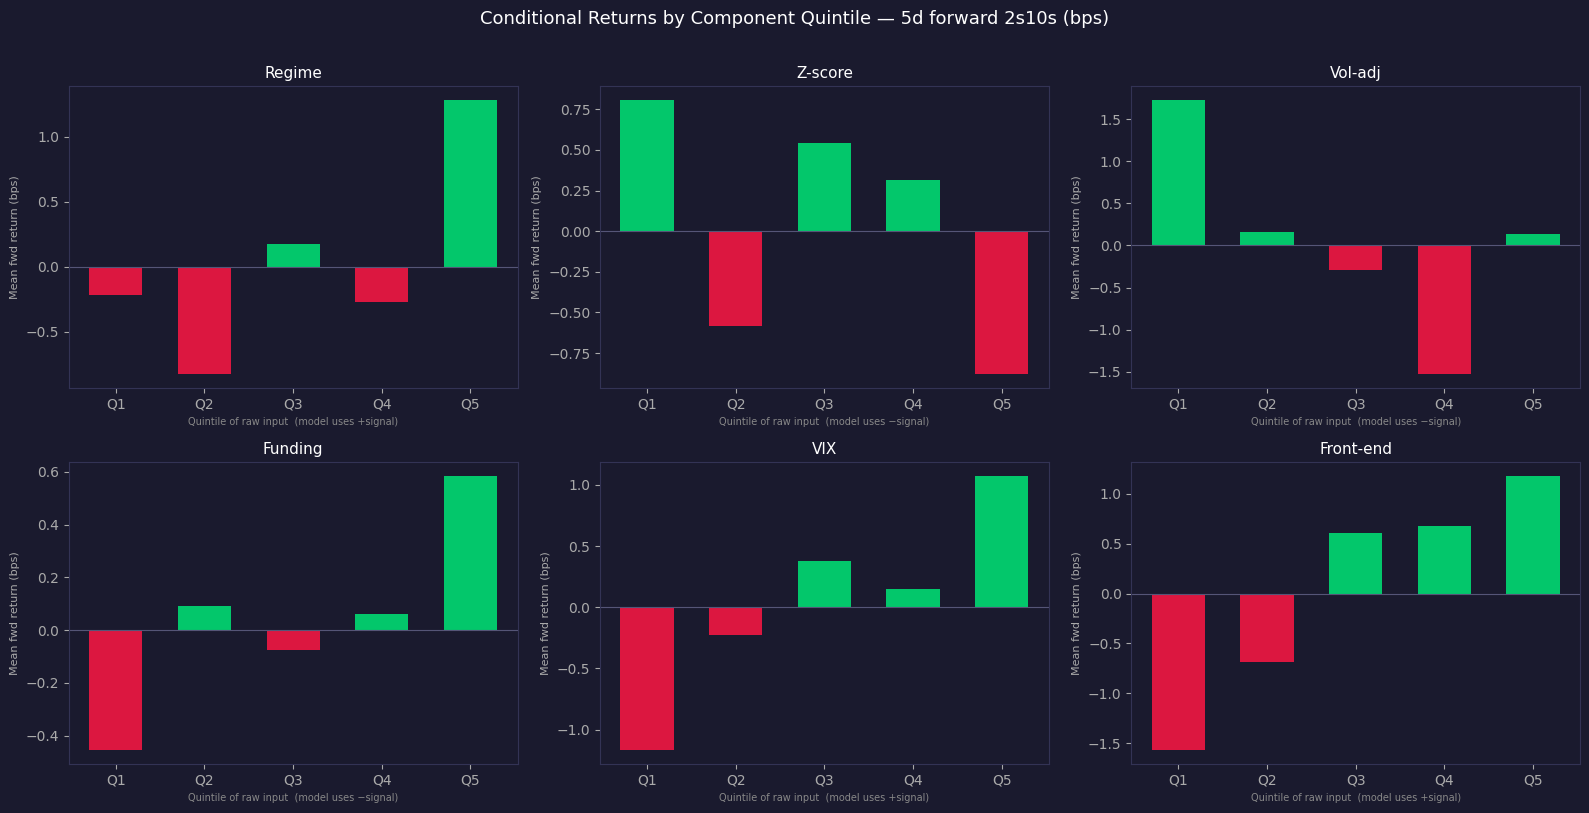

In [28]:
# ── Visual: Q1→Q5 mean return bar charts for all 6 components ────────────────
fig, axes = plt.subplots(2, 3, figsize=(16, 8), facecolor='#1a1a2e')
axes = axes.flatten()

# Sign convention: contrarian components are negatively signed in the model
# so we negate the raw input for display (to show the *aligned* direction)
sign_convention = {
    'Regime': +1,    # already mapped correctly (+1 = steepener signal)
    'Z-score': -1,   # model uses -z20, so Q5 raw z20 = most flat = steepener signal
    'Vol-adj': -1,
    'Funding': -1,
    'VIX': +1,
    'Front-end': +1,
}

for ax, (name, res) in zip(axes, cond_results.items()):
    ax.set_facecolor('#1a1a2e')
    ax.tick_params(colors='#aaaaaa')
    ax.spines[:].set_color('#333355')

    means = res['mean_return'].values
    qs    = res.index.tolist()
    colors = ['#00e676' if v > 0 else '#ff1744' for v in means]

    ax.bar(qs, means, color=colors, alpha=0.85, width=0.6)
    ax.axhline(0, color='#555577', linewidth=0.8)
    ax.set_title(f'{name}', color='white', fontsize=11)
    ax.set_ylabel('Mean fwd return (bps)', color='#aaaaaa', fontsize=8)
    ax.set_xlabel('Quintile of raw input', color='#aaaaaa', fontsize=8)

    # Annotate sign convention
    sign_note = '(model uses −signal)' if sign_convention[name] == -1 else '(model uses +signal)'
    ax.set_xlabel(f'Quintile of raw input  {sign_note}', color='#888888', fontsize=7)

plt.suptitle(f'Conditional Returns by Component Quintile — {HORIZON}d forward 2s10s (bps)',
             color='white', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

---
## Test 2 — Correlation Significance

Pearson correlation between each component and 5d forward 2s10s return.

**Pass criteria:**
- `|r| > 0.05` — economically meaningful correlation
- `p < 0.05` — statistically significant at 95% confidence
- Sign of r must match the model's sign convention

In [29]:
corr_rows = []
for name, sig in raw_inputs.items():
    combined = pd.concat([sig, fwd], axis=1).dropna()
    combined.columns = ['signal', 'fwd']
    r, p = pearsonr(combined['signal'], combined['fwd'])

    # Expected sign: contrarian = negative r (high raw signal → expect opposite move)
    # momentum = positive r (high signal → expect same direction)
    expected_sign = -1 if name in ['Z-score', 'Vol-adj', 'Funding'] else +1
    sign_ok = (r * expected_sign) > 0

    corr_rows.append({
        'Component':      name,
        'r':              round(r, 4),
        'p_value':        round(p, 4),
        'n_obs':          len(combined),
        'expected_sign':  '+' if expected_sign == 1 else '−',
        'sign_correct':   '✓' if sign_ok else '✗',
        'sig_p05':        '✓' if p < 0.05 else '✗',
        'magnitude_ok':   '✓' if abs(r) > 0.05 else '✗',
    })

corr_df = pd.DataFrame(corr_rows).set_index('Component')
corr_df

,r,p_value,n_obs,expected_sign,sign_correct,sig_p05,magnitude_ok
Component,,,,,,,
Regime,0.0644,0.0043,1964,+,✓,✓,✓
Z-score,-0.0613,0.0069,1945,−,✓,✓,✓
Vol-adj,-0.0856,0.0002,1944,−,✓,✓,✓
Funding,0.0343,0.1308,1945,−,✗,✗,✗
VIX,0.0969,0.0000,1945,+,✓,✓,✓
Front-end,0.1153,0.0000,1945,+,✓,✓,✓


---
## Test 3 — Asymmetry Check (Positive vs Negative Side)

Each component can push the score positive (steepener) or negative (flattener).
We test both sides **independently**:

- **Positive tail** (component > 0.25): does this predict steepening?
- **Negative tail** (component < −0.25): does this predict flattening?

If only one side works, the component should be capped at zero on the non-working side.

In [30]:
TAIL_THRESHOLD = 0.25  # component value threshold to define "positive" and "negative" tail

asym_rows = []
for name, comp in components.items():
    combined = pd.concat([comp, fwd], axis=1).dropna()
    combined.columns = ['comp', 'fwd']

    pos = combined[combined['comp'] >  TAIL_THRESHOLD]['fwd']
    neg = combined[combined['comp'] < -TAIL_THRESHOLD]['fwd']
    neu = combined[combined['comp'].abs() <= TAIL_THRESHOLD]['fwd']

    def stats(s, expected_positive):
        if len(s) < 20:
            return {'mean': np.nan, 'hit': np.nan, 'n': len(s), 'pass': '─'}
        mean = s.mean()
        hit  = (s > 0).mean()
        # Pass: mean return in the right direction
        passes = mean > 0 if expected_positive else mean < 0
        return {'mean': round(mean, 3), 'hit': round(hit, 3), 'n': len(s),
                'pass': '✓' if passes else '✗'}

    pos_stats = stats(pos, expected_positive=True)   # positive comp → expect steepen → positive fwd
    neg_stats = stats(neg, expected_positive=False)  # negative comp → expect flatten → negative fwd
    neu_stats = stats(neu, expected_positive=None)   # neutral — no directional expectation

    asym_rows.append({
        'Component':         name,
        'pos_mean_bps':      pos_stats['mean'],
        'pos_hit_rate':      pos_stats['hit'],
        'pos_n':             pos_stats['n'],
        'pos_pass':          pos_stats['pass'],
        'neg_mean_bps':      neg_stats['mean'],
        'neg_hit_rate':      neg_stats['hit'],
        'neg_n':             neg_stats['n'],
        'neg_pass':          neg_stats['pass'],
        'neutral_mean_bps':  neu_stats['mean'],
        'neutral_n':         neu_stats['n'],
    })

asym_df = pd.DataFrame(asym_rows).set_index('Component')

print(f'Threshold: component > {TAIL_THRESHOLD} = positive tail, < -{TAIL_THRESHOLD} = negative tail')
print(f'pos_pass = positive tail mean return > 0 (steepener signal works)')
print(f'neg_pass = negative tail mean return < 0 (flattener signal works)')
print()
asym_df

Threshold: component > 0.25 = positive tail, < -0.25 = negative tail
pos_pass = positive tail mean return > 0 (steepener signal works)
neg_pass = negative tail mean return < 0 (flattener signal works)



,pos_mean_bps,pos_hit_rate,pos_n,pos_pass,neg_mean_bps,neg_hit_rate,neg_n,neg_pass,neutral_mean_bps,neutral_n
Component,,,,,,,,,,
Regime,0.515,0.492,1073,✓,-0.538,0.404,886,✓,NaN,5
Z-score,0.149,0.483,756,✓,-0.459,0.418,706,✓,0.530,502
Vol-adj,1.266,0.530,621,✓,-0.416,0.412,570,✓,-0.639,773
Funding,-0.219,0.458,722,✗,0.402,0.448,681,✗,-0.109,561
VIX,1.029,0.496,560,✓,-0.534,0.415,860,✓,-0.114,544
Front-end,1.043,0.501,737,✓,-1.201,0.394,706,✓,0.257,521


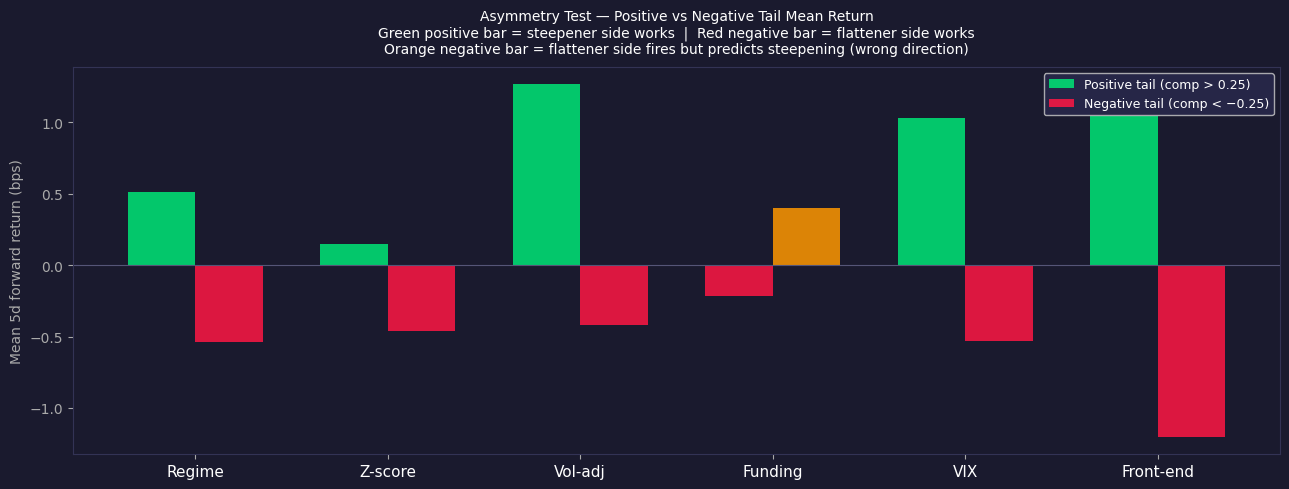

In [31]:
# ── Visual: positive vs negative tail mean return per component ───────────────
fig, ax = plt.subplots(figsize=(13, 5), facecolor='#1a1a2e')
ax.set_facecolor('#1a1a2e')
ax.tick_params(colors='#aaaaaa')
ax.spines[:].set_color('#333355')

names   = asym_df.index.tolist()
x       = np.arange(len(names))
width   = 0.35

pos_means = asym_df['pos_mean_bps'].values
neg_means = asym_df['neg_mean_bps'].values

bars1 = ax.bar(x - width/2, pos_means, width,
               color=['#00e676' if v > 0 else '#ff1744' for v in pos_means],
               alpha=0.85, label='Positive tail (comp > 0.25)')
bars2 = ax.bar(x + width/2, neg_means, width,
               color=['#ff1744' if v < 0 else '#ff9800' for v in neg_means],
               alpha=0.85, label='Negative tail (comp < −0.25)')

ax.axhline(0, color='#555577', linewidth=0.8)
ax.set_xticks(x)
ax.set_xticklabels(names, color='white', fontsize=11)
ax.set_ylabel('Mean 5d forward return (bps)', color='#aaaaaa')
ax.set_title('Asymmetry Test — Positive vs Negative Tail Mean Return\n'
             'Green positive bar = steepener side works  |  Red negative bar = flattener side works\n'
             'Orange negative bar = flattener side fires but predicts steepening (wrong direction)',
             color='white', fontsize=10, pad=10)
ax.legend(facecolor='#2a2a4e', labelcolor='white', fontsize=9)

plt.tight_layout()
plt.show()

---
## Test 4 — Ablation Study

Remove each component one at a time and measure the effect on composite score Q5 Sharpe.

**Pass criteria:** removing the component should **hurt** performance (lower Q5 Sharpe or worse monotonicity). If removing a component has no effect or improves performance, it is not earning its place.

In [32]:
def score_sharpe(score_series: pd.Series, fwd: pd.Series, n_q: int = 5) -> dict:
    """Compute Q1 and Q5 Sharpe for a given score series."""
    combined = pd.concat([score_series, fwd], axis=1).dropna()
    combined.columns = ['score', 'fwd']
    combined['q'] = pd.qcut(combined['score'], q=n_q,
                             labels=[f'Q{i}' for i in range(1, n_q+1)],
                             duplicates='drop')
    def sharpe(s):
        return s.mean() / s.std() * np.sqrt(252 / HORIZON) if s.std() > 0 else np.nan

    def aligned_sharpe(group):
        q_num = int(group.name[1])
        sign  = -1 if q_num <= n_q // 2 else +1
        s = group * sign
        return s.mean() / s.std() * np.sqrt(252 / HORIZON) if s.std() > 0 else np.nan

    by_q = combined.groupby('q', observed=True)['fwd'].agg(
        sharpe_long=sharpe,
        count='count',
    )
    aligned = combined.groupby('q', observed=True)['fwd'].apply(aligned_sharpe)

    q5_aligned = float(aligned.get('Q5', np.nan))
    q1_aligned = float(aligned.get('Q1', np.nan))
    q5_q1_spread = q5_aligned - q1_aligned if pd.notna(q5_aligned) and pd.notna(q1_aligned) else np.nan

    # Monotonicity: count how many Q_i < Q_(i+1) in mean return
    means = combined.groupby('q', observed=True)['fwd'].mean()
    monotone = sum(means.iloc[i] < means.iloc[i+1] for i in range(len(means)-1))

    return {
        'q5_sharpe':     round(q5_aligned, 3),
        'q1_sharpe':     round(q1_aligned, 3),
        'q5_q1_spread':  round(q5_q1_spread, 3),
        'monotone_steps': f'{monotone}/{len(means)-1}',
    }


# Baseline: full composite score
baseline = score_sharpe(df['composite_score'], fwd)
print('Baseline (all 6 components):', baseline)

# Ablation: remove one component at a time
ablation_rows = [{'removed': 'None (baseline)', **baseline}]

for name, comp in components.items():
    score_minus = df['composite_score'] - comp
    result      = score_sharpe(score_minus, fwd)
    delta_q5    = round(result['q5_sharpe'] - baseline['q5_sharpe'], 3)
    ablation_rows.append({
        'removed':        name,
        **result,
        'delta_q5_sharpe': delta_q5,
        'verdict':         '✓ earns place' if delta_q5 < -0.05 else
                           ('✗ remove it'  if delta_q5 > 0.10 else '─ marginal'),
    })

ablation_df = pd.DataFrame(ablation_rows).set_index('removed')
ablation_df

Baseline (all 6 components): {'q5_sharpe': 1.395, 'q1_sharpe': 1.074, 'q5_q1_spread': 0.321, 'monotone_steps': '4/4'}


,q5_sharpe,q1_sharpe,q5_q1_spread,monotone_steps,delta_q5_sharpe,verdict
removed,,,,,,
None (baseline),1.395,1.074,0.321,4/4,NaN,NaN
Regime,1.041,1.339,-0.299,4/4,-0.354,✓ earns place
Z-score,1.134,0.939,0.195,3/4,-0.261,✓ earns place
Vol-adj,0.926,0.803,0.124,4/4,-0.469,✓ earns place
Funding,1.471,2.092,-0.622,3/4,0.076,─ marginal
VIX,1.239,0.557,0.682,2/4,-0.156,✓ earns place
Front-end,0.927,0.652,0.275,3/4,-0.468,✓ earns place


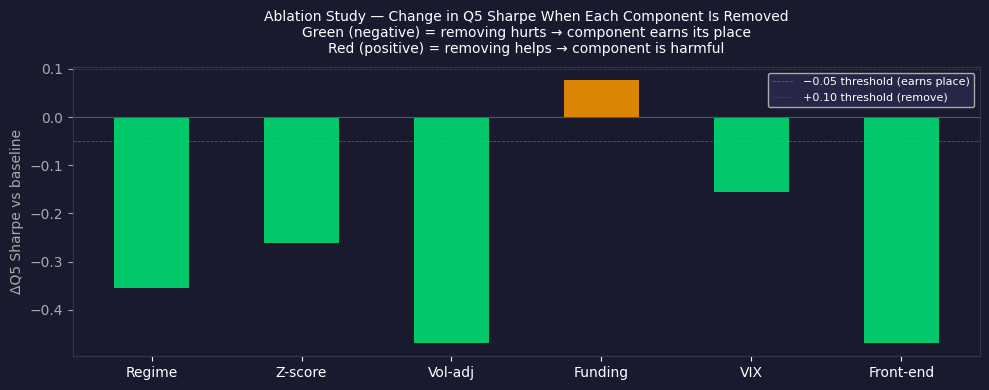

In [33]:
# ── Visual: delta Q5 Sharpe when each component is removed ───────────────────
fig, ax = plt.subplots(figsize=(10, 4), facecolor='#1a1a2e')
ax.set_facecolor('#1a1a2e')
ax.tick_params(colors='#aaaaaa')
ax.spines[:].set_color('#333355')

abl_plot = ablation_df.iloc[1:]  # exclude baseline row
deltas   = abl_plot['delta_q5_sharpe'].values
labels   = abl_plot.index.tolist()

# Negative delta = removing hurts = component earns its place (green)
# Positive delta = removing helps = component is harmful (red)
colors = ['#00e676' if d < -0.05 else ('#ff1744' if d > 0.10 else '#ff9800') for d in deltas]

ax.bar(labels, deltas, color=colors, alpha=0.85, width=0.5)
ax.axhline(0,     color='#555577', linewidth=0.8)
ax.axhline(-0.05, color='#00e676', linewidth=0.6, linestyle='--', alpha=0.5, label='−0.05 threshold (earns place)')
ax.axhline(+0.10, color='#ff1744', linewidth=0.6, linestyle='--', alpha=0.5, label='+0.10 threshold (remove)')
ax.set_ylabel('ΔQ5 Sharpe vs baseline', color='#aaaaaa')
ax.set_title('Ablation Study — Change in Q5 Sharpe When Each Component Is Removed\n'
             'Green (negative) = removing hurts → component earns its place\n'
             'Red (positive) = removing helps → component is harmful',
             color='white', fontsize=10, pad=10)
ax.legend(facecolor='#2a2a4e', labelcolor='white', fontsize=8)
ax.tick_params(axis='x', colors='white')

plt.tight_layout()
plt.show()

---
## Test 5 — Redundancy Check

Correlation matrix between all 6 component series.

**Pass criteria:** no two components should have `|r| > 0.5` — high correlation means double-counting the same information.

In [34]:
comp_df = pd.DataFrame(components).dropna()
corr_matrix = comp_df.corr().round(3)

# Flag high correlations
high_corr = []
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):
        r = corr_matrix.iloc[i, j]
        if abs(r) > 0.5:
            high_corr.append((corr_matrix.index[i], corr_matrix.columns[j], r))

print('Component correlation matrix:')
print(corr_matrix.to_string())
print()
if high_corr:
    print('⚠ High correlations (|r| > 0.5):')
    for a, b, r in high_corr:
        print(f'  {a} ↔ {b}: r = {r:+.3f}')
else:
    print('✓ No component pairs with |r| > 0.5')

Component correlation matrix:
           Regime  Z-score  Vol-adj  Funding    VIX  Front-end
Regime      1.000    0.640    0.317    0.091 -0.066     -0.085
Z-score     0.640    1.000    0.430    0.100 -0.104     -0.099
Vol-adj     0.317    0.430    1.000    0.044 -0.058      0.002
Funding     0.091    0.100    0.044    1.000 -0.036      0.113
VIX        -0.066   -0.104   -0.058   -0.036  1.000     -0.020
Front-end  -0.085   -0.099    0.002    0.113 -0.020      1.000

⚠ High correlations (|r| > 0.5):
  Regime ↔ Z-score: r = +0.640


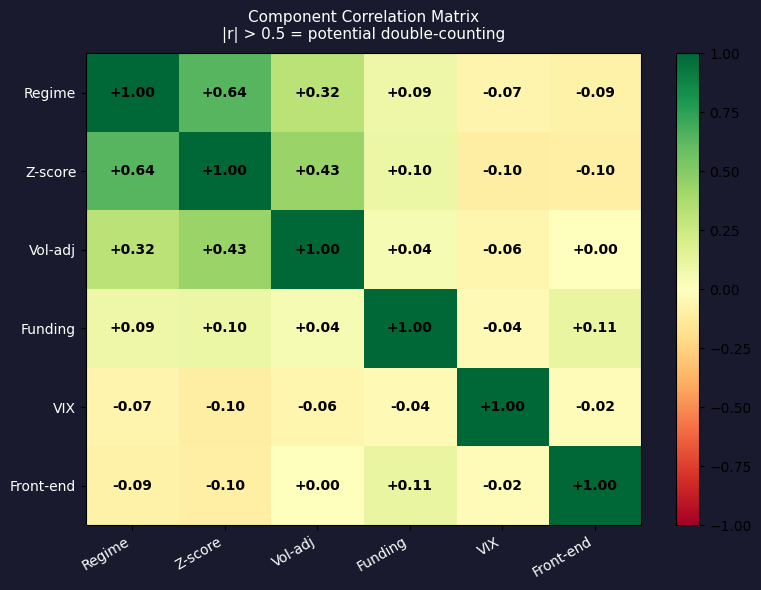

In [35]:
# ── Visual: correlation heatmap ───────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6), facecolor='#1a1a2e')
ax.set_facecolor('#1a1a2e')

mat = corr_matrix.values
names = corr_matrix.columns.tolist()

im = ax.imshow(mat, cmap='RdYlGn', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(im, ax=ax)

ax.set_xticks(range(len(names)))
ax.set_yticks(range(len(names)))
ax.set_xticklabels(names, color='white', rotation=30, ha='right')
ax.set_yticklabels(names, color='white')

for i in range(len(names)):
    for j in range(len(names)):
        ax.text(j, i, f'{mat[i,j]:+.2f}', ha='center', va='center',
                color='black', fontsize=10, fontweight='bold')

ax.set_title('Component Correlation Matrix\n|r| > 0.5 = potential double-counting',
             color='white', fontsize=11, pad=10)

plt.tight_layout()
plt.show()

---
## Summary — Pass / Fail per Component

Consolidates all five tests into a single verdict table.

In [36]:
summary_rows = []
for name in components.keys():
    c_row  = corr_df.loc[name]
    a_row  = asym_df.loc[name]

    # Monotonicity check
    res   = cond_results[name]
    means = res['mean_return'].values
    is_contrarian = name in ['Z-score', 'Vol-adj', 'Funding']
    monotone_ok = means[-1] > means[0] if not is_contrarian else means[0] > means[-1]

    pos_works = a_row['pos_pass'] == '✓'
    neg_works = a_row['neg_pass'] == '✓'
    asymmetry = 'both'     if (pos_works and neg_works) else \
                'pos only' if pos_works else \
                'neg only' if neg_works else 'neither'

    # Fix: check index membership instead of truthiness of a Series
    ablation_verdict = ablation_df.loc[name, 'verdict'] if name in ablation_df.index else '─'

    passes = sum([
        c_row['sig_p05'] == '✓',
        c_row['sign_correct'] == '✓',
        monotone_ok,
        asymmetry in ('both', 'pos only'),
        ablation_verdict == '✓ earns place',
    ])

    summary_rows.append({
        'Component':    name,
        'r':            c_row['r'],
        'p_sig':        c_row['sig_p05'],
        'sign_ok':      c_row['sign_correct'],
        'monotone':     '✓' if monotone_ok else '✗',
        'asymmetry':    asymmetry,
        'ablation':     ablation_verdict,
        'tests_passed': f'{passes}/5',
        'overall':      '✓ KEEP'   if passes >= 4 else
                        '⚠ REVIEW' if passes == 3 else
                        '✗ REMOVE',
    })

summary_df = pd.DataFrame(summary_rows).set_index('Component')

def colour_verdict(val):
    if '✓' in str(val): return 'color: #66ff66'
    if '✗' in str(val): return 'color: #ff6666'
    if '⚠' in str(val): return 'color: #ffaa00'
    return ''

summary_df.style.applymap(colour_verdict)


/var/folders/zh/8x6bgqps2zj8yvb5jq9tqt3h0000gn/T/ipykernel_64288/2240715528.py:51: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  summary_df.style.applymap(colour_verdict)


,r,p_sig,sign_ok,monotone,asymmetry,ablation,tests_passed,overall
Component,,,,,,,,
Regime,0.064400,✓,✓,✓,both,✓ earns place,5/5,✓ KEEP
Z-score,-0.061300,✓,✓,✓,both,✓ earns place,5/5,✓ KEEP
Vol-adj,-0.085600,✓,✓,✓,both,✓ earns place,5/5,✓ KEEP
Funding,0.034300,✗,✗,✗,neither,─ marginal,0/5,✗ REMOVE
VIX,0.096900,✓,✓,✓,both,✓ earns place,5/5,✓ KEEP
Front-end,0.115300,✓,✓,✓,both,✓ earns place,5/5,✓ KEEP


In [37]:
def compare_variants(variants: dict, fwd: pd.Series, n_q: int = 5) -> pd.DataFrame:
    """Run score_sharpe on multiple score variants and compare Q1-Q5 Sharpe."""
    rows = []
    for label, score_series in variants.items():
        combined = pd.concat([score_series, fwd], axis=1).dropna()
        combined.columns = ['score', 'fwd']
        combined['q'] = pd.qcut(combined['score'], q=n_q,
                                 labels=[f'Q{i}' for i in range(1, n_q+1)],
                                 duplicates='drop')
        def aligned(group):
            sign = -1 if int(group.name[1]) <= n_q // 2 else +1
            s = group * sign
            return s.mean() / s.std() * np.sqrt(252 / HORIZON) if s.std() > 0 else np.nan

        sharpes = combined.groupby('q', observed=True)['fwd'].apply(aligned).round(3)
        means   = combined.groupby('q', observed=True)['fwd'].mean().round(3)
        rows.append({
            'variant': label,
            **{f'Q{i}_sharpe': sharpes.get(f'Q{i}', np.nan) for i in range(1, n_q+1)},
            **{f'Q{i}_mean':   means.get(f'Q{i}',   np.nan) for i in range(1, n_q+1)},
        })
    return pd.DataFrame(rows).set_index('variant')


# Build the three score variants (Funding already excluded from all)
v5  = (components['Regime'] + components['Z-score'] + components['Vol-adj']
       + components['VIX'] + components['Front-end'])

v4a = (components['Z-score'] + components['Vol-adj']
       + components['VIX'] + components['Front-end'])          # drop Regime

v4b = (components['Regime'] + components['Vol-adj']
       + components['VIX'] + components['Front-end'])          # drop Z-score

variants = {
    '5-comp  (Regime + Z-score + Vol-adj + VIX + FE)': v5,
    '4-comp A (Z-score + Vol-adj + VIX + FE)':         v4a,
    '4-comp B (Regime + Vol-adj + VIX + FE)':          v4b,
}

result = compare_variants(variants, fwd)

print('Q5 Sharpe comparison:')
q5_cols = [c for c in result.columns if 'sharpe' in c]
display(result[q5_cols].style
    .background_gradient(cmap='RdYlGn', axis=None)
    .format('{:.3f}'))

print('\nQ5 Mean Return (bps):')
mean_cols = [c for c in result.columns if 'mean' in c]
display(result[mean_cols].style
    .background_gradient(cmap='RdYlGn', axis=None)
    .format('{:+.3f}'))


Q5 Sharpe comparison:


,Q1_sharpe,Q2_sharpe,Q3_sharpe,Q4_sharpe,Q5_sharpe
variant,,,,,
5-comp (Regime + Z-score + Vol-adj + VIX + FE),2.092,-0.596,-0.416,0.238,1.471
4-comp A (Z-score + Vol-adj + VIX + FE),2.486,0.200,0.481,0.566,1.363
4-comp B (Regime + Vol-adj + VIX + FE),1.855,0.175,0.081,0.029,1.642



Q5 Mean Return (bps):


,Q1_mean,Q2_mean,Q3_mean,Q4_mean,Q5_mean
variant,,,,,
5-comp (Regime + Z-score + Vol-adj + VIX + FE),-2.145,+0.684,-0.441,+0.295,+1.746
4-comp A (Z-score + Vol-adj + VIX + FE),-2.539,-0.209,+0.523,+0.728,+1.639
4-comp B (Regime + Vol-adj + VIX + FE),-1.947,-0.191,+0.087,+0.033,+2.158


---
## Regime vs Z-score: Keep Both or Drop One?

Regime and Z-score have r = 0.64 — they overlap but are not identical.
This cell compares three model variants:

- **5-component** (current): Regime + Z-score + Vol-adj + VIX + Front-end
- **4-component A** (drop Regime): Z-score + Vol-adj + VIX + Front-end
- **4-component B** (drop Z-score): Regime + Vol-adj + VIX + Front-end
